In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Load the dataset
df = pd.read_csv('final_dataset.csv')

In [ ]:
df.head()

,Product,Base location,Destination,Mode of transport,Transport partner,Fuel consumption,Distance travelled (in Kms),Load factor,Tonne - Kilometer (tkm),Initial cost (USD),Final cost (USD),CO2 Emission (in Kg),Savings (USD)
0,Product4,USA,Italy,Sea,Ignas Logistics Services,18.641474,1127,35,39445,1987,1996,49.962746,9
1,Product4,Japan,London,Air,Ignas Logistics Services,120305.218839,3177,18,57186,4899,100242,4.549013,95343
2,Product4,Japan,Italy,Train,IBridge International Logistic,165.676477,9814,18,176652,1186,1251,1775.593239,65
3,Product3,Germany,London,Air,IBridge International Logistic,63202.465425,9131,48,438288,1255,51343,66.364755,50088
4,Product5,Belgium,Italy,Train,IBridge International Logistic,195.544843,6339,19,120441,4321,4398,1025.684421,77


## RNN savings

In [ ]:
# Ensure the column names match with the provided dataset
num_cols = ['Fuel consumption', 'Distance travelled (in Kms)', 'Load factor', 'Tonne - Kilometer (tkm)',
            'Initial cost (USD)', 'Final cost (USD)', 'CO2 Emission (in Kg)']
cat_cols = ['Product', 'Base location', 'Destination', 'Mode of transport', 'Transport partner']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols)

# Drop the target variable
X = df_encoded.drop(['CO2 Emission (in Kg)'], axis=1)
y = df_encoded['CO2 Emission (in Kg)']

In [ ]:
# Split the dataset into training and testing sets with a 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for RNN input (samples, time steps, features)
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [ ]:
# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                3950      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 4001 (15.63 KB)
Trainable params: 4001 (15.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150
110/110 [==============================] - 2s 6ms/step - loss: 3096074.2500 - val_loss: 2997301.5000
Epoch 2/150
110/110 [==============================] - 0s 4ms/step - loss: 3083985.5000 - val_loss: 2982787.5000
Epoch 3/150
110/110 [==============================] - 0s 4ms/step - loss: 3069322.5000 - val_loss: 2968068.7500
Epoch 4/150
110/110 [==============================] - 0s 4ms/step - loss: 3055995.0000 - val_loss: 2955365.5000
Epoch 5/150
110/110 [==============================] - 0s 3ms/step - loss: 3044247.0000 - val_loss: 2943993.5000
Epoch 6/150
110/110 [==============================] - 0s 3ms/step - loss: 3033526.0000 - val_loss: 2933371.0000
Epoch 7/150
110/110 [==============================] - 0s 3ms/step - loss: 3023521.7500 - val_loss: 2923415.2500
Epoch 8/150
110/110 [==============================] - 0s 3ms/step - loss: 3013958.7500 - val_loss: 2913907.7500
Epoch 9/150
110/110 [==============================] - 0s 3ms/step - loss: 3004754.2500 - val_lo

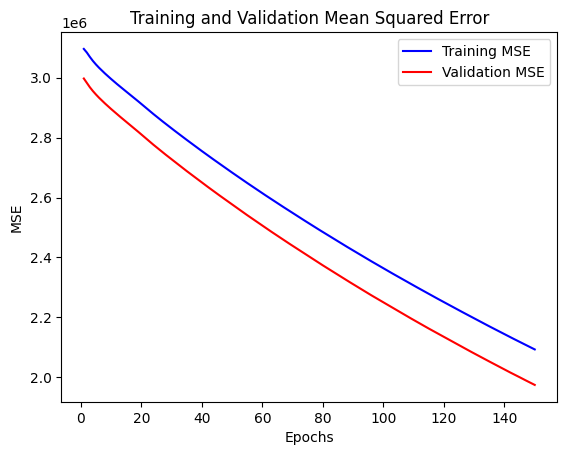

In [ ]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train_rnn, y_train, epochs=150, batch_size=32, validation_data=(X_test_rnn, y_test))

# Extract MSE values from history
train_mse_values = history.history['loss']
val_mse_values = history.history['val_loss']

# Plot MSE values
epochs = range(1, len(train_mse_values) + 1)
plt.plot(epochs, train_mse_values, 'b', label='Training MSE')
plt.plot(epochs, val_mse_values, 'r', label='Validation MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
model.save('rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Neural model Co2 emission

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df = pd.read_csv('final_dataset.csv')
num_cols = ['Fuel consumption', 'Distance travelled (in Kms)', 'Load factor', 'Tonne - Kilometer (tkm)',
            'Initial cost (USD)', 'Final cost (USD)', 'CO2 Emission (in Kg)']
y_true = df['CO2 Emission (in Kg)']
cat_cols = ['Product', 'Base location', 'Destination', 'Mode of transport', 'Transport partner']
df_encoded = pd.get_dummies(df[cat_cols])
X = pd.concat([df[num_cols], df_encoded], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                1856      
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3969 (15.50 KB)
Trainable params: 3969 (15.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(X_scaled, y_true, epochs=20, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_scaled)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Epoch 1/20
157/157 [==============================] - 1s 2ms/step - loss: 3050581.7500
Epoch 2/20
157/157 [==============================] - 0s 2ms/step - loss: 2664831.7500
Epoch 3/20
157/157 [==============================] - 0s 2ms/step - loss: 1455847.2500
Epoch 4/20
157/157 [==============================] - 0s 2ms/step - loss: 548740.0000
Epoch 5/20
157/157 [==============================] - 0s 2ms/step - loss: 360693.8438
Epoch 6/20
157/157 [==============================] - 0s 2ms/step - loss: 304993.9375
Epoch 7/20
157/157 [==============================] - 0s 2ms/step - loss: 263702.8125
Epoch 8/20
157/157 [==============================] - 0s 2ms/step - loss: 226960.8438
Epoch 9/20
157/157 [==============================] - 0s 2ms/step - loss: 195699.5469
Epoch 10/20
157/157 [==============================] - 0s 2ms/step - loss: 168253.4844
Epoch 11/20
157/157 [==============================] - 0s 2ms/step - loss: 142565.6875
Epoch 12/20
157/157 [============================

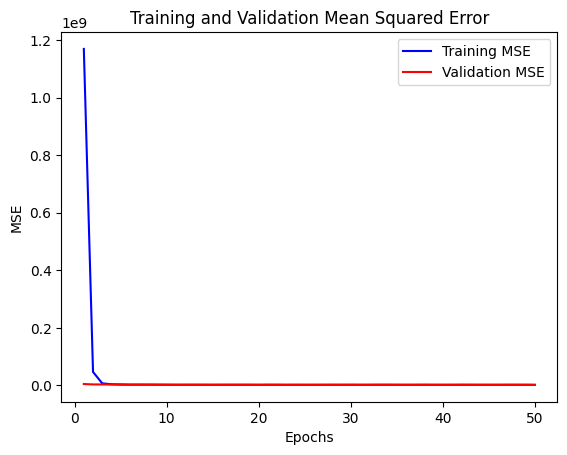

In [ ]:
import matplotlib.pyplot as plt

# Extract MSE values from history
train_mse_values = history.history['loss']
val_mse_values = history.history['val_loss']

# Plot MSE values
epochs = range(1, len(train_mse_values) + 1)
plt.plot(epochs, train_mse_values, 'b', label='Training MSE')
plt.plot(epochs, val_mse_values, 'r', label='Validation MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
model.predict(X_test)

array([-342.45710867, -633.75325757, -288.58677605, ..., 4680.00433358,
        -99.39122263, -362.9951452 ])

In [ ]:
y_pred=model.predict(X_test)

#### Checking R2 Score

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.6988907106403803

Text(0, 1, 'r-squared = 0.699')

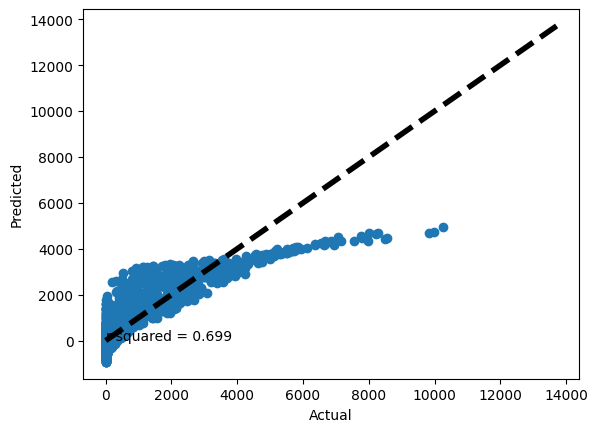

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_pred)), (0, 1))

In [ ]:
import pickle
pickle.dump(model,open('RNN.pkl','wb'))

In [ ]:
import pickle

# Step 1: Load the saved model
with open('RNN.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

predictions = loaded_model.predict(X_new)

# Step 4: Use the predictions as needed
print(predictions)
